In [1]:
import mxnet as mx
from mxnet import init, gluon, nd, autograd, image
from mxnet.gluon import nn
import numpy as np
import pickle as p
import matplotlib.pyplot as plt
from time import time
%matplotlib inline
ctx = mx.gpu()
data_dir = '/home/sinyer/python/data/cifar10'

In [2]:
def load_cifar(route = data_dir+'/cifar-10-batches-py'):
    def load_batch(filename):
        with open(filename, 'rb')as f:
            data_dict = p.load(f, encoding='latin1')
            X = data_dict['data']
            Y = data_dict['labels']
            X = X.reshape(10000, 3, 32,32).astype("float")
            Y = np.array(Y)
            return X, Y
    def load_labels(filename):
        with open(filename, 'rb') as f:
            label_names = p.load(f, encoding='latin1')
            names = label_names['label_names']
            return names
    label_names = load_labels(route + "/batches.meta")
    x1, y1 = load_batch(route + "/data_batch_1")
    x2, y2 = load_batch(route + "/data_batch_2")
    x3, y3 = load_batch(route + "/data_batch_3")
    x4, y4 = load_batch(route + "/data_batch_4")
    x5, y5 = load_batch(route + "/data_batch_5")
    test_pic, test_label = load_batch(route + "/test_batch")
    train_pic = np.concatenate((x1, x2, x3, x4, x5))
    train_label = np.concatenate((y1, y2, y3, y4, y5))
    return train_pic, train_label, test_pic, test_label

def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

def evaluate_accuracy(test_data, net, ctx):
    acc = 0.
    for data, label in test_data:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        acc = acc + accuracy(output, label)
    return acc / len(test_data)

def augment(data, auglist):
    data = nd.pad(data, pad_width=(0,0,0,0,2,2,2,2),mode='constant',constant_value=0)
    data = nd.transpose(data, (0,2,3,1))
    temp = []
    for d in data:
        for aug in auglist:
            d = aug(d)
        temp.append(d)
    data = nd.stack(*temp)
    data = nd.transpose(data, (0,3,1,2))
    return data

In [3]:
train_pic, train_label, test_pic, test_label = load_cifar()

batch_size = 128
train_pic = np.transpose(train_pic.astype('float32')/255, (0,2,3,1))
test_pic = np.transpose(test_pic.astype('float32')/255, (0,2,3,1))
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
for i in range(3):
    train_pic[:,:,:,i] = (train_pic[:,:,:,i] - mean[i])/std[i]
    test_pic[:,:,:,i] = (test_pic[:,:,:,i] - mean[i])/std[i]
train_pic = np.transpose(train_pic, (0,3,1,2))
test_pic = np.transpose(test_pic, (0,3,1,2))
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(train_pic, train_label.astype('float32')), 
                                   batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(test_pic, test_label.astype('float32')), 
                                  batch_size, shuffle=False)

In [4]:
aug_train = image.CreateAugmenter(data_shape=(3, 32, 32), rand_crop=True, rand_mirror=True)

net = gluon.nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=20, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=50, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(128, activation="relu"),
        nn.Dense(10)
    )
net.initialize(ctx=ctx)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 5e-4})

0 loss:2.0119 tracc:0.2570 teacc:0.3713 time:14.268
10 loss:1.3100 tracc:0.5544 teacc:0.5581 time:7.804
20 loss:1.2569 tracc:0.5781 teacc:0.6130 time:7.651
30 loss:1.1894 tracc:0.6005 teacc:0.5855 time:7.535
40 loss:1.1639 tracc:0.6079 teacc:0.6289 time:7.671
50 loss:0.9303 tracc:0.6849 teacc:0.7162 time:7.679
60 loss:0.6075 tracc:0.7905 teacc:0.7745 time:7.693
70 loss:0.5282 tracc:0.8144 teacc:0.7878 time:7.538
80 loss:0.4438 tracc:0.8454 teacc:0.8059 time:7.599
90 loss:0.4015 tracc:0.8602 teacc:0.8078 time:7.486
100 loss:0.3907 tracc:0.8643 teacc:0.8119 time:7.539
tracc:0.868638 teacc:0.811412


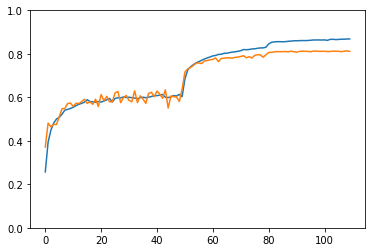

In [5]:
epochs = 110

a, b = [], []
for epoch in range(epochs):
    if epoch == 50:
        trainer.set_learning_rate(0.01)
    if epoch == 80:
        trainer.set_learning_rate(0.001)
    train_loss = 0.
    train_acc = 0.
    start = time()
    for data, label in train_data:
        data = augment(data, aug_train).as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            l = loss(output, label)
        l.backward()
        trainer.step(batch_size)
        train_loss = train_loss + nd.mean(l).asscalar()
        train_acc = train_acc + accuracy(output, label)
    test_acc = evaluate_accuracy(test_data, net, ctx)
    
    if epoch%10 == 0:
        print(epoch, 'loss:%.4f tracc:%.4f teacc:%.4f time:%.3f'%(
            train_loss/len(train_data), train_acc/len(train_data), test_acc, time()-start)) 
    a.append(train_acc/len(train_data))
    b.append(test_acc)

print('tracc:%f teacc:%f'%(train_acc/len(train_data), test_acc))
plt.plot(np.arange(epochs), a, np.arange(epochs), b)
plt.ylim(0,1)
plt.show()